In [42]:
%matplotlib notebook
import numpy as np
from modsim import *
import math
import numpy as np
# 125 meters in between each building in distance, 11 meters in height

In [56]:
def make_frisbee_system(v, alpha, duration):

    x= 0
    y = 0
    vx = v*math.cos(np.radians(alpha))
    vy = v*math.sin(alpha)
    init = State(x=x, y=y, vx=vx, vy=vy)
    g = 9.8 #* UNITS.meter / UNITS.second**2
    m = .175 #* UNITS.kilogram # Mass of frisbee
    rho = 1.23  #* UNITS.kilogram/UNITS.meter**3 # Density of air
    area = 0.0568 #* UNITS.meter**2 # Surface area of frisbee
    CL0 = 0.1 # Lift coefficient alpha=0.
    CLA = 1.4 # Alpha-dependent lift coefficient
    # Drag coefficient when alpha = 0
    CD0 = 0.08
    # Alpha-dependent drag coefficient
    CDA = 2.72 
    # Constant associated with launch angle.
    alpha_constant = -4
    # Launch angle (in degrees).
    alpha = alpha

    # Now that we have lots of constants, we can calculate the actual coefficients.
    # Lift coefficient.
    CL = (CL0 + CLA*alpha_constant*math.pi/180)*4
    # print(CL)
    # Drag coefficient.
    CD = (CD0 + CDA*((alpha - alpha_constant) * math.pi/180)**2)/2
    # print(CD)
    # Array of times around which this should be created.
    ts = linspace(0, duration,101)
    # Return our system, because real object oriented programming is "soooo overrated"
    return System(init=init, g=g, m=m, rho=rho, area=area, CL=CL, CD=CD, ts=ts)

def frisbee_slope_func(state, t, system):
    """
    """
    x, y, vx, vy = state
    unpack(system)

    # Make some useful vectors.
    # a_grav = Vector(0, -g)
    # v = Vector(vx, vy)
    
    # Make some change vectors.
    ax = -(rho*(vx**2)*area*CD)/2/m
    ay = ((rho*(vy**2)*area*(CL))/2/m - g)
    
    return vx, vy, ax, ay

In [44]:
system = make_frisbee_system(14, 10, 20)
frisbee_slope_func(system.init, 0, system)


(13.787308542170912,
 -7.6162955524511773,
 -9.1975631256260151,
 -9.669066293781718)

<IPython.core.display.Javascript object>


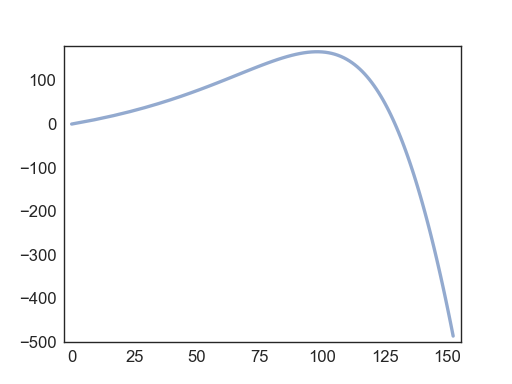

In [57]:
# Frisbee system more like... frisbee system
frisbee = make_frisbee_system(50, 8,20)
run_odeint(frisbee, frisbee_slope_func)
#frisbee.results.x=frisbee.results.x*100
#print(frisbee.results.y)
#plot(frisbee.results.x, label="x direction")
#plot(frisbee.results.y, label="y direction")
plot(frisbee.results.x,frisbee.results.y)
#decorate(title="Frisbee Trajectory Model", xlabel="X", ylabel="Y", legend=True)

In [46]:
#################################################### PENDULUM SYSTEM ############################################################
def make_pendulum_system():
    """
    Makes a frisbee object, but really it's a System object with a state object.

        
    returns: System with init, g, m, rho, C_d, area, and ts
    """
    g = 9.8
    m = .10
    area = .3871
    rho = 1.23
    v_term = 60
    duration = 30
    length0 = 1
    angle = (270 - 45)
    k = 40
    theta = np.deg2rad(angle)
    x, y = pol2cart(theta, length0)
    P = Vector(x, y)
    V = Vector(0, 0)
    
    init = State(x=P.x, y=P.y, vx=V.x, vy=V.y)
    mg = m*g
    C_d = (2*mg)/(rho*area*(v_term**2))
    ts = linspace(0, duration, 501)
    
    return System(init=init, g=g, m=m, rho=rho,
                  C_d=C_d, area=area, length0=length0,
                  k=k, ts=ts)

def pendulum_slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with length0, m, k
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    ax = k*length0*x/(m*sqrt(x**2 + y**2)) - k*x/m
    ay = -g + k*length0*y/(m*sqrt(x**2 + y**2)) - k*y/m

    return vx, vy, ax, ay

In [47]:
# Wow! The pendulum system!
system = make_pendulum_system()
run_odeint(system, pendulum_slope_func)
# plot(system.results.x)
# plot(system.results.y, label="y direction")
# decorate(title="Frisbee x-direction Trajectory Model", xlabel="Time (s)", ylabel="Distance (m)")
#plot(system.results.x)

In [48]:
# Now, let's think about combining models together... It'll be great!!!!!!!!!!

def combine_models(velocity, angle, duration):
    """
    Combines frisbee and pendulum models to describe a system where a frisbee flies through the air
    from (0, 0)
    """    
    frisbee = make_frisbee_system(velocity, angle, duration)
    run_odeint(frisbee, frisbee_slope_func)
    time_series = linrange(0, duration)   
    
    fx = interpolate(frisbee.results.x)
    i_fx = fx(time_series)
    fy = interpolate(frisbee.results.y)
    i_fy = fy(time_series)
    
    pendulum = make_pendulum_system()
    run_odeint(pendulum, pendulum_slope_func)
    px = interpolate(pendulum.results.x)
    i_px = px(time_series)
    py = interpolate(pendulum.results.y)
    i_py = py(time_series)  
    
    x_combined = np.add(i_fx, i_px)
    print(x_combined)
    plot(time_series, x_combined)
    y_combined = np.add(i_fy, i_py)
    plot(time_series, y_combined) 
    plot(x_combined, y_combined)
    
    
    
#combine_models(30, 10, 10)
          
    

In [49]:
# Now, let's actually solve the problem (shocking, I know)

# We need to find the velocity and angle necessary to go 125 meters horizontally and 11 meteres down vertically.


#                between 124.5 and 125.5, -11 and -12 meters for y
# x, y = x = 125 and y = 11.5 AND 0 pendulum angle < 90

def sweep_velocities:
make_frisbee_system(v, alpha, duration)
make_pendulum_system





SyntaxError: invalid syntax (<ipython-input-49-54aaa8e2200d>, line 9)